In [9]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
dataset = "ChestX-ray14"
ratios = ["100-0", "75-25", "50-50", "25-75", "0-100"]
n_folds = 10
n_runs = 1

exp_dir = Path(f"../../results/ratios_single/trained_models{dataset}")
out_dir = Path(f"../../results/ratios_single/plots")
out_dir.mkdir(parents=True, exist_ok=True)

In [11]:
df_all = pd.DataFrame()
for ratio in ratios:
    for fold in range(1, n_folds+1):
        for run in range(1, n_runs+1):
            df = pd.read_csv(exp_dir / f"{ratio}/fold_{fold}/run_{run}/predictions/predictions.csv")
            df["fold"] = fold
            df["run"] = run
            df["ratio"] = ratio
            df["y_dist"] = np.abs(df["y"] - df["y_pred"])
            df_all = pd.concat([df_all, df], axis=0)

In [12]:
df_grouped = df_all.groupby(["ratio", "fold", "run", "a"])["y_dist"].mean().reset_index()
df_grouped = df_grouped.rename(columns={"y_dist": "mae"})
df_grouped["a"] = df_grouped["a"].map({0: "Male", 1: "Female"}) 

In [13]:
df_ratios = df_grouped.groupby(["ratio", "a"])["mae"].agg(["mean", "std"]).reset_index()
df_ratios_m = df_ratios[df_ratios["a"] == "Male"].reset_index().iloc[[1, 4, 3, 2, 0], :]
df_ratios_f = df_ratios[df_ratios["a"] == "Female"].reset_index().iloc[[1, 4, 3, 2, 0], :]

print(df_ratios_m.round(3))
print(df_ratios_f.round(3))

   index  ratio     a   mean    std
1      3  100-0  Male  4.633  0.125
4      9  75-25  Male  4.679  0.189
3      7  50-50  Male  4.795  0.149
2      5  25-75  Male  4.802  0.153
0      1  0-100  Male  5.265  0.189
   index  ratio       a   mean    std
1      2  100-0  Female  5.823  0.301
4      8  75-25  Female  4.888  0.109
3      6  50-50  Female  4.717  0.149
2      4  25-75  Female  4.565  0.105
0      0  0-100  Female  4.527  0.109


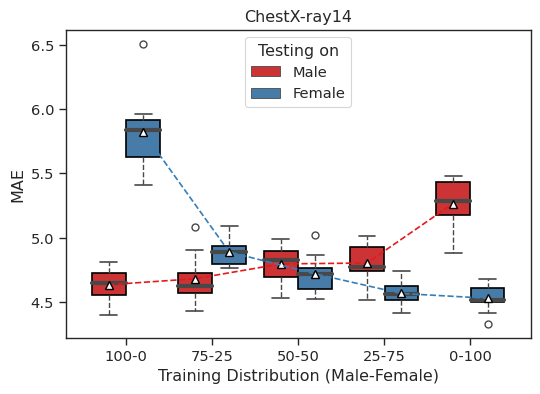

In [14]:
sns.set_theme(style="ticks")
sns.set_context("paper", font_scale=1.2)
palette_name = "Set1" 

flierprops = dict(marker="o", markerfacecolor="white")
meanprops = dict(markerfacecolor="blue", markeredgecolor="blue")
medianprops = dict(linewidth=3)
boxprops = dict(edgecolor="black")
whiskerprops = dict(linestyle="--", linewidth=1)
plot_params = {"showmeans": False, "flierprops": flierprops, "whiskerprops": whiskerprops, "boxprops": boxprops, "meanprops": meanprops, "medianprops": medianprops, "palette": palette_name}

plt.figure(figsize=(6, 4))

ax = sns.boxplot(data=df_grouped, x="ratio", y="mae", hue="a", order=ratios, zorder=1, **plot_params)

# plt.gca().yaxis.set_major_formatter('{:.1f}'.format)

plt.xlabel("Training Distribution (Male-Female)")
plt.ylabel("MAE")
plt.title(f"{dataset}")
plt.legend(title="Testing on", loc="upper center")#, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

if dataset == "UTKFace":
    plt.ylim(5, 10)

means = df_grouped.groupby(["a", "ratio"])["mae"].mean().reset_index()
means_f = means.iloc[[1, 4, 3, 2, 0], :]
means_m = means.iloc[[6, 9, 8, 7, 5], :]

hue_colors = sns.color_palette(palette_name, n_colors=len(df_grouped['a'].unique()))
for i, hue_value in enumerate([means_m, means_f]):
    if i == 0: # Male
        plt.plot(np.arange(5)-0.2, means_m["mae"], color=hue_colors[i % len(hue_colors)], marker="^", linestyle='--', linewidth=1.2, markersize=6, markeredgecolor="black", markerfacecolor="white")
    else:
        plt.plot(np.arange(5)+0.2, means_f["mae"], color=hue_colors[i % len(hue_colors)], marker="^", linestyle='--', linewidth=1.2, markersize=6, markeredgecolor="black", markerfacecolor="white")

plt.savefig(out_dir / f"mae_ratios_{dataset}.png", dpi=300, bbox_inches="tight")
plt.show()

In [15]:
def cumulative_score(estimated_ages, true_ages, n):
    if not isinstance(estimated_ages, np.ndarray):
        estimated_ages = np.array(estimated_ages)
    if not isinstance(true_ages, np.ndarray):
        true_ages = np.array(true_ages)
    if len(estimated_ages) != len(true_ages):
        raise ValueError("Arrays of estimated ages and true ages must have the same length.")

    absolute_errors = np.abs(estimated_ages - true_ages)
    count = np.sum(absolute_errors <= n)
    K = len(estimated_ages)
    CS_n = count / K

    return CS_n

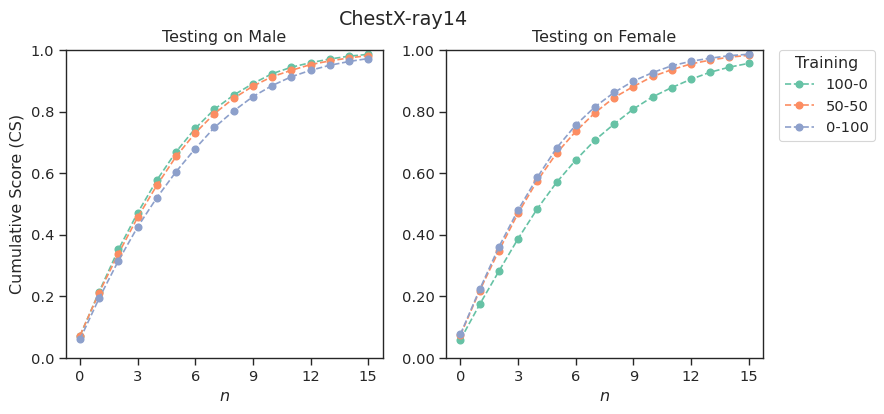

In [16]:
sns.set_theme(style="ticks")
sns.set_context("paper", font_scale=1.2)
colors = list(sns.color_palette("Set2").as_hex())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

n_values = list(range(0, 16))

for i, ratio in enumerate(ratios[::2]):
    y_true = df_all[(df_all["a"] == 0) & (df_all["ratio"] == ratio)]["y"].values
    y_pred = df_all[(df_all["a"] == 0) & (df_all["ratio"] == ratio)]["y_pred"].values
    cs_values = []
    for n in n_values:
        cs_n = cumulative_score(y_pred, y_true, n)
        cs_values.append(cs_n)
    
    ax1.plot(n_values, cs_values, marker="o", linestyle='--', label=ratio, c=colors[i])
    ax1.set_title("Testing on Male")
    ax1.set_xlabel(r'$n$')
    ax1.set_ylabel('Cumulative Score (CS)')
    ax1.set_ylim([0.0, 1.0])
    ax1.set_xticks(n_values[::3])  

for i, ratio in enumerate(ratios[::2]):
    y_true = df_all[(df_all["a"] == 1) & (df_all["ratio"] == ratio)]["y"].values
    y_pred = df_all[(df_all["a"] == 1) & (df_all["ratio"] == ratio)]["y_pred"].values
    cs_values = []
    for n in n_values:
        cs_n = cumulative_score(y_pred, y_true, n)
        cs_values.append(cs_n)
    
    ax2.plot(n_values, cs_values, marker="o", linestyle='--', label=ratio, c=colors[i])
    ax2.set_title("Testing on Female")
    ax2.set_xlabel(r'$n$')
    # ax2.set_ylabel('Cumulative Score (CS)')
    ax2.set_ylim([0.0, 1.0])
    ax2.set_xticks(n_values[::3])

# put legend outside the figure
plt.gca().yaxis.set_major_formatter('{:.2f}'.format)
plt.legend(title="Training", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.suptitle(f"{dataset}")

plt.savefig(out_dir / f"cs_ratios_{dataset}.png", dpi=300, bbox_inches="tight")